# Example 22 - Coal Measures

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 6875 m wide (W-E extent) and 9954 m high (N-S extent). The model represents coal measures which were mapped on the surface and at depth using boreholes. 

The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example22.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example22/'
gg.download_gemgis_data.download_tutorial_data(filename="example22_coal_measures.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example22.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo22.shp')
topo.head()

,id,Z,geometry
0,None,950,"LINESTRING (6001.096 12.580, 6136.515 195.703,..."
1,None,900,"LINESTRING (5508.664 11.041, 5542.518 117.222,..."
2,None,850,"LINESTRING (3151.144 4.886, 3160.377 221.864, ..."
3,None,950,"LINESTRING (1889.286 18.735, 1878.514 141.843,..."
4,None,1000,"LINESTRING (21.120 7446.770, 227.327 7482.163,..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(138.86817548746515, 0.5, 'Y [m]')

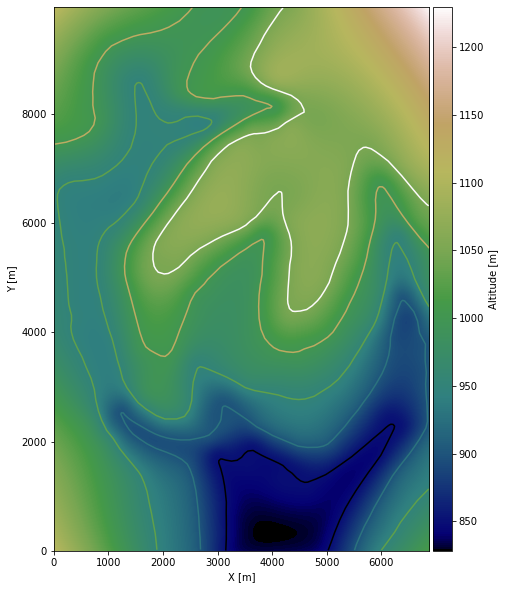

In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0,6875,0,9954], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster22.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example22.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces22.shp')
interfaces.head()

,id,formation,geometry
0,None,MiddleCoal,"LINESTRING (7.271 6412.662, 159.617 6449.594, ..."
1,None,MiddleCoal,"LINESTRING (2429.423 7811.477, 2543.298 7865.3..."
2,None,MiddleCoal,"LINESTRING (2314.009 2839.449, 2423.267 2800.9..."
3,None,MiddleCoal,"LINESTRING (6865.930 1990.004, 6756.672 1866.8..."
4,None,MiddleCoal,"LINESTRING (824.401 4356.757, 964.436 4259.809..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,MiddleCoal,POINT (7.271 6412.662),7.27,6412.66,951.72
205,MiddleCoal,POINT (6536.616 5044.623),6536.62,5044.62,945.45
223,MiddleCoal,POINT (1772.333 4008.976),1772.33,4008.98,1008.61
222,MiddleCoal,POINT (1675.385 3935.111),1675.39,3935.11,1004.46
221,MiddleCoal,POINT (1603.059 3916.645),1603.06,3916.65,1000.21


In [10]:
interfaces_lowercoal = gpd.read_file(file_path + 'interfaces22a.shp')
interfaces_lowercoal['Z'] = interfaces_lowercoal['Z']+600
interfaces_lowercoal.head()

,id,formation,Z,geometry
0,None,LowerCoal,700,"LINESTRING (1544.583 9919.704, 1381.465 9491.9..."
1,None,LowerCoal,650,"LINESTRING (2147.813 9941.247, 2003.161 9708.8..."
2,None,LowerCoal,750,"LINESTRING (16.504 3161.069, 290.419 3342.654,..."
3,None,LowerCoal,800,"LINESTRING (3540.473 5306.228, 3508.157 5141.5..."
4,None,LowerCoal,700,"LINESTRING (3365.044 11.041, 3417.365 180.315,..."


In [11]:
interfaces_coords_lowercoal = gg.vector.extract_xy(gdf=interfaces_lowercoal)
interfaces_coords_lowercoal = interfaces_coords_lowercoal.sort_values(by='formation', ascending=False)
interfaces_coords_lowercoal.head()

,formation,Z,geometry,X,Y
0,LowerCoal,700.00,POINT (1544.583 9919.704),1544.58,9919.70
206,LowerCoal,700.00,POINT (3951.346 2165.433),3951.35,2165.43
213,LowerCoal,700.00,POINT (4414.541 3553.476),4414.54,3553.48
212,LowerCoal,700.00,POINT (4332.981 3356.503),4332.98,3356.50
211,LowerCoal,700.00,POINT (4245.267 3102.593),4245.27,3102.59


In [12]:
import pandas as pd
interfaces_coords = pd.concat([interfaces_coords, interfaces_coords_lowercoal])
interfaces_coords = interfaces_coords[interfaces_coords['formation'].isin(['MiddleCoal','LowerCoal'])].reset_index() 
interfaces_coords

,index,formation,geometry,X,Y,Z
0,0,MiddleCoal,POINT (7.271 6412.662),7.27,6412.66,951.72
1,205,MiddleCoal,POINT (6536.616 5044.623),6536.62,5044.62,945.45
2,223,MiddleCoal,POINT (1772.333 4008.976),1772.33,4008.98,1008.61
3,222,MiddleCoal,POINT (1675.385 3935.111),1675.39,3935.11,1004.46
4,221,MiddleCoal,POINT (1603.059 3916.645),1603.06,3916.65,1000.21
...,...,...,...,...,...,...
635,104,LowerCoal,POINT (5250.137 7492.935),5250.14,7492.94,750.00
636,103,LowerCoal,POINT (5247.059 7556.028),5247.06,7556.03,750.00
637,102,LowerCoal,POINT (5205.510 7612.966),5205.51,7612.97,750.00
638,101,LowerCoal,POINT (5156.267 7637.587),5156.27,7637.59,750.00


### Plotting the Interface Points

Text(138.5447183098592, 0.5, 'Y [m]')

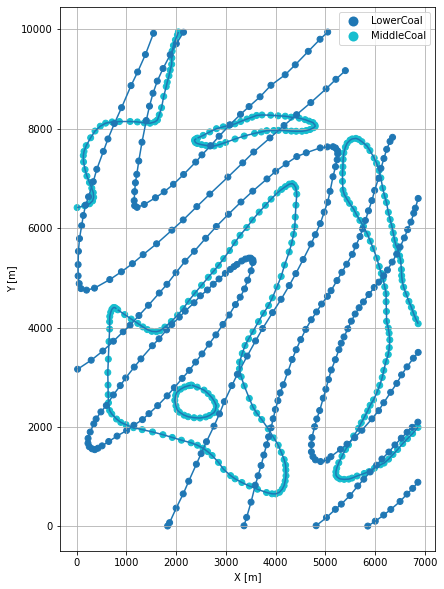

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_lowercoal.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example22.png" width="800">

In [14]:
strikes = gpd.read_file(file_path + 'strikes22.shp')
strikes.head()

,id,formation,Z,geometry
0,4,MiddleCoal1,1050,"LINESTRING (5399.405 6655.800, 4311.437 5714.023)"
1,3,MiddleCoal1,1000,"LINESTRING (5844.133 5890.991, 3757.451 4279.814)"
2,2,MiddleCoal1,950,"LINESTRING (6116.510 5133.876, 3277.330 3110.287)"
3,1,MiddleCoal1,900,"LINESTRING (6231.924 4242.882, 3554.323 2383.949)"


### Calculate Orientations for each formation

In [15]:
orientations_coal1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='MiddleCoal1'].sort_values(by='Z', ascending=True).reset_index())
orientations_coal1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,3.79,144.85,925.00,POINT (4795.021 3717.749),1.00,MiddleCoal1,4795.02,3717.75
1,4.24,143.74,975.00,POINT (4748.856 4603.742),1.00,MiddleCoal1,4748.86,4603.74
2,3.59,141.62,1025.00,POINT (4828.107 5635.157),1.00,MiddleCoal1,4828.11,5635.16


In [16]:
gradients = gpd.read_file(file_path + 'gradients22.shp')
gradients.head()

,id,formation,dZ,geometry
0,None,LowerCoal,50,"LINESTRING (1199.880 9087.185, 1618.448 8957.922)"
1,None,LowerCoal,50,"LINESTRING (664.360 7856.104, 1307.600 7699.141)"
2,None,LowerCoal,50,"LINESTRING (119.607 4772.246, 1193.725 6431.128)"
3,None,LowerCoal,50,"LINESTRING (5207.049 8991.776, 4653.062 9558.074)"
4,None,LowerCoal,50,"LINESTRING (3668.198 7622.199, 3181.921 8173.107)"


In [17]:
orientations_lowercoal = gg.vector.extract_orientations_from_map(gdf=gradients)
orientations_lowercoal = gg.vector.extract_xyz(gdf=orientations_lowercoal, dem=topo_raster)
orientations_lowercoal

,formation,geometry,azimuth,dip,X,Y,polarity,Z
0,LowerCoal,POINT (1409.164 9022.553),107.16,6.51,1409.16,9022.55,1.00,973.93
1,LowerCoal,POINT (985.980 7777.623),103.71,4.32,985.98,7777.62,1.00,981.51
2,LowerCoal,POINT (656.666 5601.687),32.92,1.45,656.67,5601.69,1.00,945.90
3,LowerCoal,POINT (4930.056 9274.925),315.63,3.61,4930.06,9274.92,1.00,1090.31
4,LowerCoal,POINT (3425.059 7897.653),318.57,3.89,3425.06,7897.65,1.00,995.92
5,LowerCoal,POINT (2487.899 6960.493),314.81,4.42,2487.90,6960.49,1.00,1019.35
6,LowerCoal,POINT (3529.701 7108.222),315.90,5.13,3529.70,7108.22,1.00,1067.49
7,LowerCoal,POINT (2172.434 5789.427),316.92,4.88,2172.43,5789.43,1.00,1062.76
8,LowerCoal,POINT (2386.335 5018.463),313.43,3.99,2386.33,5018.46,1.00,1034.22
9,LowerCoal,POINT (1443.019 3995.127),309.88,4.69,1443.02,3995.13,1.00,989.47


### Merging Orientations

In [18]:
import pandas as pd
orientations = pd.concat([orientations_coal1]).reset_index()
orientations['formation'] = ['MiddleCoal', 'MiddleCoal','MiddleCoal']
orientations = pd.concat([orientations, orientations_lowercoal]).reset_index()
orientations = orientations[orientations['formation'].isin(['LowerCoal', 'MiddleCoal'])]
orientations.head()

,level_0,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,0.00,3.79,144.85,925.00,POINT (4795.021 3717.749),1.00,MiddleCoal,4795.02,3717.75
1,1,1.00,4.24,143.74,975.00,POINT (4748.856 4603.742),1.00,MiddleCoal,4748.86,4603.74
2,2,2.00,3.59,141.62,1025.00,POINT (4828.107 5635.157),1.00,MiddleCoal,4828.11,5635.16
3,0,NaN,6.51,107.16,973.93,POINT (1409.164 9022.553),1.00,LowerCoal,1409.16,9022.55
4,1,NaN,4.32,103.71,981.51,POINT (985.980 7777.623),1.00,LowerCoal,985.98,7777.62


### Plotting the Orientations

Text(138.5447183098592, 0.5, 'Y [m]')

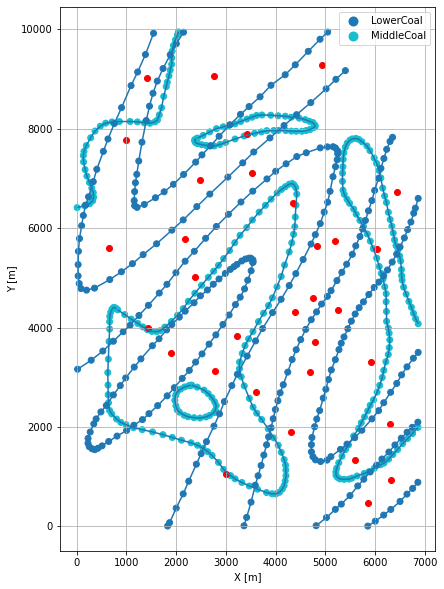

In [19]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_lowercoal.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [20]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [21]:
geo_model = gp.create_model('Model22')
geo_model

Model22  2021-04-05 14:03

### Initiate Data

In [22]:
gp.init_data(geo_model, [0,6875,0,9954,500,1250], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model22  2021-04-05 14:03

### Model Surfaces

In [23]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,MiddleCoal,Default series,1,#015482,1
1,LowerCoal,Default series,2,#9f0052,2


### Mapping the Stack to Surfaces

In [24]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('MiddleCoal','LowerCoal'),   
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

,surface,series,order_surfaces,color,id
0,MiddleCoal,Strata1,1,#015482,1
1,LowerCoal,Strata1,2,#9f0052,2
2,Basement,Strata1,3,#ffbe00,3


### Adding additional Orientations

In [25]:
geo_model.add_orientations(X=380, Y=9550, Z=1025, surface='MiddleCoal', orientation = [107,15,1])
geo_model.add_orientations(X=1700, Y=9775, Z=1025, surface='MiddleCoal', orientation = [107,15,1])

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,4795.02,3717.75,925.00,0.04,-0.05,1.00,0.01,MiddleCoal
1,4748.86,4603.74,975.00,0.04,-0.06,1.00,0.01,MiddleCoal
2,4828.11,5635.16,1025.00,0.04,-0.05,1.00,0.01,MiddleCoal
32,380.00,9550.00,1025.00,0.25,-0.08,0.97,0.01,MiddleCoal
33,1700.00,9775.00,1025.00,0.25,-0.08,0.97,0.01,MiddleCoal
3,1409.16,9022.55,973.93,0.11,-0.03,0.99,0.01,LowerCoal
4,985.98,7777.62,981.51,0.07,-0.02,1.00,0.01,LowerCoal
5,656.67,5601.69,945.90,0.01,0.02,1.00,0.01,LowerCoal
6,4930.06,9274.92,1090.31,-0.04,0.05,1.00,0.01,LowerCoal
7,3425.06,7897.65,995.92,-0.04,0.05,1.00,0.01,LowerCoal


### Showing the Number of Data Points

In [26]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,MiddleCoal,Strata1,1,#015482,1,327,5
1,LowerCoal,Strata1,2,#9f0052,2,313,29
2,Basement,Strata1,3,#ffbe00,3,0,0


### Loading Digital Elevation Model

In [27]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster22.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  34.375     ,   49.77      ,  503.75      ],
       [  34.375     ,   49.77      ,  511.25      ],
       [  34.375     ,   49.77      ,  518.75      ],
       ...,
       [6869.98906706, 9928.98994975, 1228.36560059],
       [6869.98906706, 9938.99396985, 1228.96081543],
       [6869.98906706, 9948.99798995, 1229.55761719]])

### Plotting Input Data

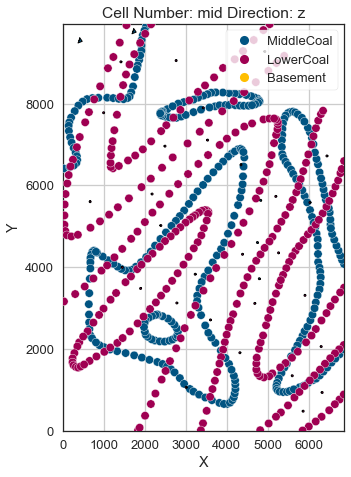

In [28]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

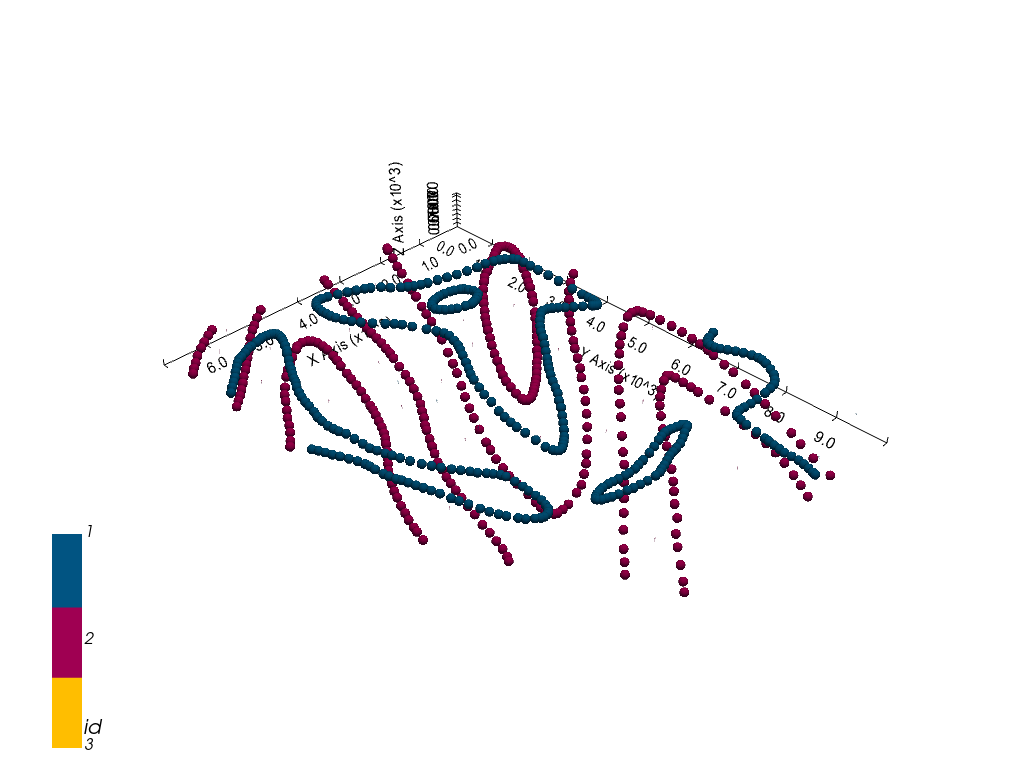

In [29]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [30]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range             12120.65
$C_o$           3497862.88
drift equations        [3]


### Computing Model

In [31]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

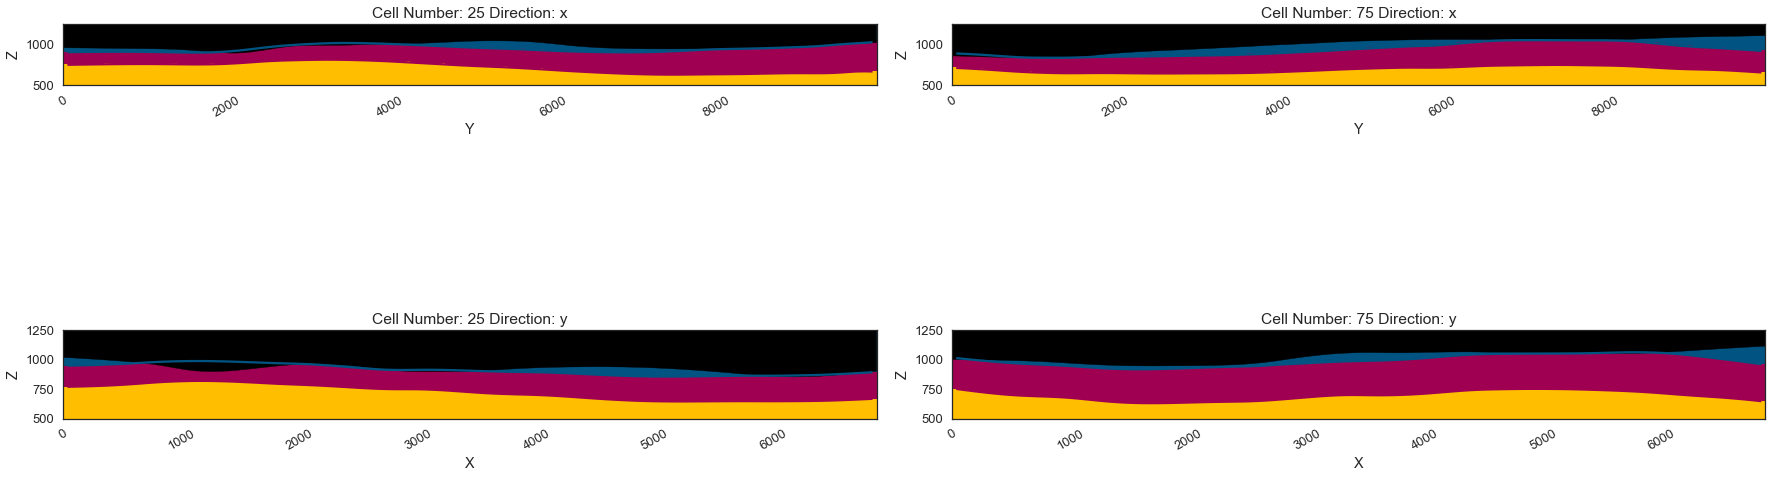

In [32]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

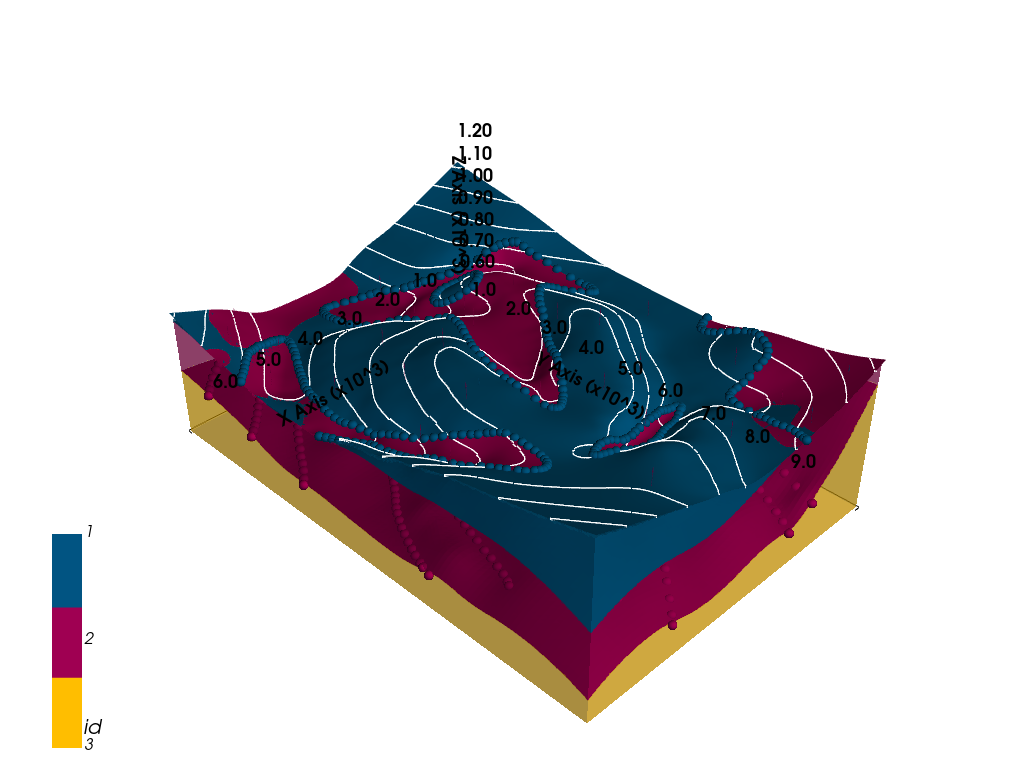

In [33]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True, ve=5)